In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from dataset import get_dataset


In [2]:
def show(img, gray=False):
    plt.axis('off')
    if gray:
        plt.imshow(img, plt.cm.binary)
        plt.show()
        return
    plt.imshow(img)
    plt.show()



In [3]:
def hair_density(image, label, show_images=False):    
    blur_image = cv2.blur(image,(10,10))
    grayScale = cv2.cvtColor(blur_image, cv2.COLOR_RGB2GRAY)
        
    kernel = cv2.getStructuringElement(1,(17,17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
   
    num = cv2.countNonZero(threshold)
    size = threshold.shape[-1]*threshold.shape[1]
    
    if num/size >= 0.02 and show_images:
        figure, axes = plt.subplots(1, 3, figsize=(12, 3))
        axes[0].axis('off')
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[1].axis('off')
        axes[1].imshow(grayScale, plt.cm.binary)
        axes[1].set_title('Gray Scale')
        axes[2].axis('off')
        axes[2].imshow(threshold)
        axes[2].set_title('Detected Hairs')
        plt.show()
    return num/size


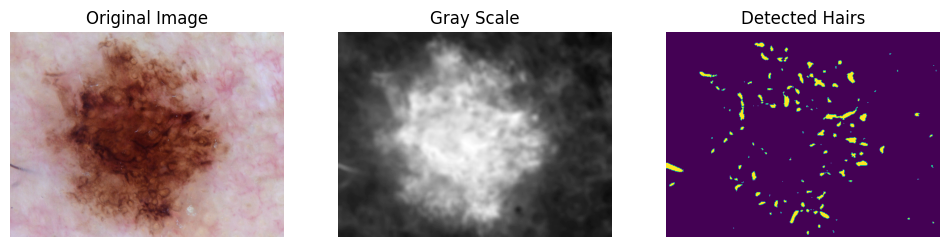

Image: 1
ISIC_0034529
0
0.021158333333333335


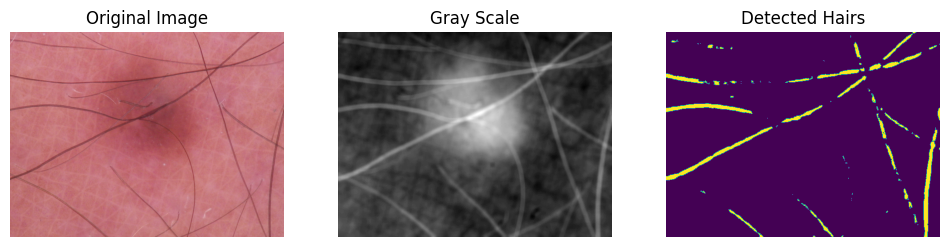

Image: 2
ISIC_0034530
1
0.034880555555555554


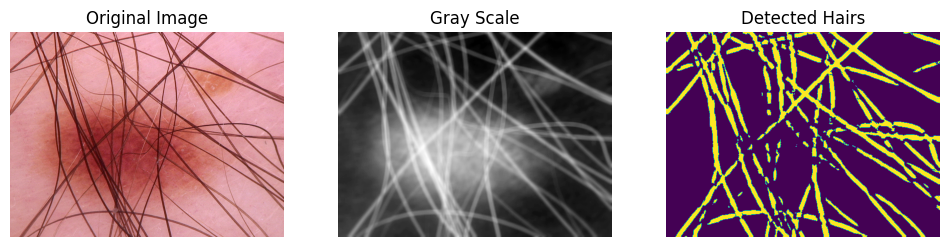

Image: 3
ISIC_0034533
1
0.16302222222222224


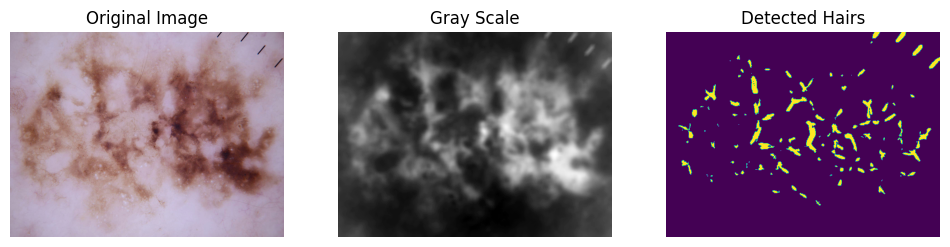

Image: 4
ISIC_0034547
3
0.03281944444444444


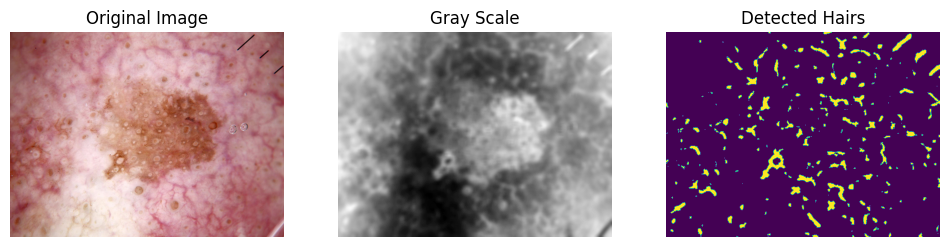

Image: 5
ISIC_0034548
0
0.04956666666666667
Found 5 hair images
{0: 0, 1: 0, 2: 0, 3: 0}


ValueError: All arrays must be of the same length

In [4]:


data_set = get_dataset("test", use_plain_transform=True, id_as_label=True, num_classes=4)

data_loader = DataLoader(data_set, batch_size=1, shuffle=False, num_workers=0)

hair_densities = {"isic_id": [], "hair_density": [], "high_hair_density": []}
counter = 0
label_count ={0: 0, 1:0, 2:0, 3:0}
for batch, labels in data_loader:
    isic_id = labels[0][0]
    #print(labels[1][0].item())
    img = batch[0].permute(1,2,0).numpy()
    img = img.astype(np.uint8)
    density = hair_density(img, labels, show_images=True)
    if density >= 0.02:
        print(f"Image: {counter+1}")
        print(isic_id)
        label = labels[1][0].item()
        print(labels[1][0].item())
        print(density)
        counter += 1
        if counter >= 5:
            break
    else:
        hair_densities["high_hair_density"].append(0)
    
    hair_densities["isic_id"].append(isic_id)
    hair_densities["hair_density"].append(density)
    
print(f"Found {counter} hair images")
print(label_count)

dataframe_hair_densities = pd.DataFrame(hair_densities)
print(dataframe_hair_densities)
dataframe_hair_densities.to_csv("hair_densities4.csv", index=False)


In [15]:
# Check labeled images manually

df = pd.read_csv("hair_densities.csv")
print(df.head())

data_set = get_dataset("test", use_plain_transform=True, id_as_label=True, num_classes=4)
data_loader = DataLoader(data_set, batch_size=1, shuffle=False, num_workers=0)

label_count ={0: 0, 1:0, 2:0, 3:0}

for batch, labels in data_loader:
    isic_id = labels[0][0]
    img = batch[0].permute(1,2,0).numpy()
    img = img.astype(np.uint8)
    label = labels[1][0].item()
    if df[df['isic_id'] == isic_id]['high_hair_density'].item() == 1:
        plt.axis('off')
        plt.imshow(img)
        plt.show()
        confirm = input()
        if confirm == "y":
            label_count[label] = label_count[label]+1
        else:
            df.loc[df['isic_id'] == isic_id, 'high_hair_density'] = 0

print(label_count)
#df.to_csv("hair_densities_manual.csv", index=False)



        isic_id  hair_density  high_hair_density
0  ISIC_0034524      0.000175                  0
1  ISIC_0034525      0.000125                  0
2  ISIC_0034526      0.010222                  0
3  ISIC_0034527      0.015058                  0
4  ISIC_0034528      0.000439                  0
{0: 18, 1: 105, 2: 14, 3: 27}


In [17]:
# Export csv for binary classification

df = pd.read_csv("hair_densities_manual.csv")

hair_densities = {"isic_id": [], "hair_density": [], "high_hair_density": []}

data_set = get_dataset("test", use_plain_transform=True, id_as_label=True, num_classes=4)
data_loader = DataLoader(data_set, batch_size=1, shuffle=False, num_workers=0)

for batch, labels in data_loader:
    isic_id = labels[0][0]
    img = batch[0].permute(1,2,0).numpy()
    img = img.astype(np.uint8)
    label = labels[1][0].item()
    if label <= 1:
        high_density = df[df['isic_id'] == isic_id]['high_hair_density'].item()
        density = df[df['isic_id'] == isic_id]['hair_density'].item()

        hair_densities["isic_id"].append(isic_id)
        hair_densities["hair_density"].append(density)
        hair_densities["high_hair_density"].append(high_density)

dataframe_hair_densities = pd.DataFrame(hair_densities)
print(dataframe_hair_densities)
dataframe_hair_densities.to_csv("binary_hair_densities_manual.csv", index=False)      


           isic_id  hair_density  high_hair_density
0     ISIC_0034524      0.000175                  0
1     ISIC_0034525      0.000125                  0
2     ISIC_0034527      0.015058                  0
3     ISIC_0034528      0.000439                  0
4     ISIC_0034529      0.021158                  0
...            ...           ...                ...
1075  ISIC_0036056      0.018283                  0
1076  ISIC_0036057      0.001908                  0
1077  ISIC_0036058      0.001208                  0
1078  ISIC_0036059      0.002442                  0
1079  ISIC_0036061      0.044497                  1

[1080 rows x 3 columns]
